# Hyperspectral Image Classification
insert small description here

In [2]:
import os
import random
import itertools
from random import shuffle
import h5py
import json

import numpy as np
import scipy
import scipy.io as sio # Scipy input and output
import scipy.ndimage 
from skimage.transform import rotate 
import spectral # Module for processing hyperspectral image data.
import matplotlib 
%matplotlib inline

# scikit-learn imports 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score

# keras imports 
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization, Dropout, Input
from keras.models import Model
from keras.models import load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils




Using TensorFlow backend.
/home/ali/anaconda2/envs/mypython3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ali/anaconda2/envs/mypython3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ali/anaconda2/envs/mypython3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ali/anaconda2/

## Dataset Loading  and Preproccesing



In [4]:
def  load_dataset(dataset):
    """load dataset parameters from config.json"""
    
    with open('./config.json') as f:
        config = json.loads(f.read())
        params = config[dataset]
        data = sio.loadmat(params['img_path'])[params['img']]
        labels = sio.loadmat(params['gt_path'])[params['gt']]
        num_classes = params['num_classes']
        target_names = params['target_names']
        
    return data,labels,num_classes,target_names
        

In [5]:
def apply_pca(X, num_components=75):
    """apply pca to X and return new_X"""
    
    new_X = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=num_components, whiten=True)
    new_X = pca.fit_transform(new_X)
    new_X = np.reshape(new_X, (X.shape[0],X.shape[1], num_components))
    return new_X, pca

In [6]:
def pad_with_zeros(X, margin=2):
    """apply zero padding to X with margin"""
    
    new_X = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    new_X[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return new_X


In [7]:
def create_patches(X, y, window_size=5, remove_zero_labels = True):
    """create patch from image. suppose the image has the shape (w,h,c) then the patch shape is
    (w*h,window_size,window_size,c)"""
    
    margin = int((window_size - 1) / 2)
    zero_padded_X = pad_with_zeros(X, margin=margin)
    # split patches
    patches_data = np.zeros((X.shape[0] * X.shape[1], window_size, window_size, X.shape[2]))
    patchs_labels = np.zeros((X.shape[0] * X.shape[1]))
    patch_index = 0
    for r in range(margin, zero_padded_X.shape[0] - margin):
        for c in range(margin, zero_padded_X.shape[1] - margin):
            patch = zero_padded_X[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patches_data[patch_index, :, :, :] = patch
            patchs_labels[patch_index] = y[r-margin, c-margin]
            patch_index = patch_index + 1
    if remove_zero_labels:
        patches_data = patches_data[patchs_labels>0,:,:,:]
        patchs_labels = patchs_labels[patchs_labels>0]
        patchs_labels -= 1
    return patches_data, patchs_labels

In [8]:
def split_train_test_set(X, y, test_ratio=0.10):
    """split dataset into train set and test set with test_ratio"""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=345,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test


In [9]:
def oversample_weak_classes(X, y):
    """"balance the dataset by prforming oversample of weak classes (making each class have close labels_counts)"""
    unique_labels, labels_counts = np.unique(y, return_counts=True)
    

    max_count = np.max(labels_counts)
    labels_inverse_ratios = max_count / labels_counts  
    #print(labels_inverse_ratios)
    # repeat for every label and concat
    print(labels_inverse_ratios)
    new_X = X[y == unique_labels[0], :, :, :].repeat(round(labels_inverse_ratios[0]), axis=0)
    new_Y = y[y == unique_labels[0]].repeat(round(labels_inverse_ratios[0]), axis=0)
    for label, labelInverseRatio in zip(unique_labels[1:], labels_inverse_ratios[1:]):
        cX = X[y== label,:,:,:].repeat(round(labelInverseRatio), axis=0)
        cY = y[y == label].repeat(round(labelInverseRatio), axis=0)
        new_X = np.concatenate((new_X, cX))
        new_Y = np.concatenate((new_Y, cY))
    np.random.seed(seed=42)
    rand_perm = np.random.permutation(new_Y.shape[0])
    new_X = new_X[rand_perm, :, :, :]
    new_Y = new_Y[rand_perm]
    unique_labels, labels_counts = np.unique(new_Y, return_counts=True)
    
#     print(unique_labels.shape)
#     print(unique_labels)
#     print(labels_counts.shape)
#     print(labels_counts)
    return new_X, new_Y


In [10]:
def augment_data(X_train):
    """augment the data by taking each patch and randomly performing 
    a flip(up/down or right/left) or a rotation"""
    
    for i in range(int(X_train.shape[0]/2)):
        patch = X_train[i,:,:,:]
        num = random.randint(0,2)
        if (num == 0):
            
            flipped_patch = np.flipud(patch)
        if (num == 1):
            
            flipped_patch = np.fliplr(patch)
        if (num == 2):
            
            no = random.randrange(-180,180,30)
            flipped_patch = scipy.ndimage.interpolation.rotate(patch, no,axes=(1, 0),
                                                               reshape=False, output=None, order=3, mode='constant', cval=0.0, prefilter=False)
    
    
        patch2 = flipped_patch
        X_train[i,:,:,:] = patch2
    
    return X_train

In [88]:
#Parameters
dataset = "Salinas" # Indian_pines or PaviaU or or Salinas  . check config.json
window_size = 9
num_pca_components = 30
test_ratio = 0.4

### Preproccesing steps
<!---img src="./images/1.png" alt="diagram">

In [89]:
X, y , num_classes , target_names = load_dataset(dataset)
print("Initial {}".format(X.shape))

X,pca = apply_pca(X,num_pca_components)
print("PCA {}".format(X.shape))

X_patches, y_patches = create_patches(X, y, window_size=window_size)
print("Patches {} ".format(X_patches.shape))

X_train, X_test, y_train, y_test = split_train_test_set(X_patches, y_patches, test_ratio)
print("Split {}".format(X_train.shape))


y_train = np_utils.to_categorical(y_train) # convert class labels to on-hot encoding
y_test = np_utils.to_categorical(y_test)



Initial (512, 217, 204)
PCA (512, 217, 30)
Patches (54129, 9, 9, 30) 
Split (32477, 9, 9, 30)


## Defining and Training the model

In [90]:
X_train = X_train.reshape(-1,window_size,window_size,num_pca_components,1)
X_test = X_test.reshape(-1,window_size,window_size,num_pca_components,1)
X_train.shape


(32477, 9, 9, 30, 1)

In [91]:

## input layer
input_layer = Input((window_size, window_size, num_pca_components,1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16,kernel_size=(3,3,5),activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32,kernel_size=(3,3,3),activation='relu')(conv_layer2)

conv3d_shape = conv_layer3._keras_shape
conv_layer3 = Reshape((conv3d_shape[1],conv3d_shape[2],conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64,kernel_size=(3,3),activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(units=256,activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128,activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)

output_layer = Dense(units=num_classes,activation='softmax')(dense_layer2)
    
model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 9, 9, 30, 1)       0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 7, 7, 24, 8)       512       
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 5, 5, 20, 16)      5776      
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 3, 3, 18, 32)      13856     
_________________________________________________________________
reshape_4 (Reshape)          (None, 3, 3, 576)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 1, 64)          331840    
_________________________________________________________________
flatten_4 (Flatten)          (None, 64)                0         
__________

In [92]:
adam = Adam(lr=0.001,decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, batch_size=256, epochs=5)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5


In [ ]:
model.save('./saved_models/model_hybrid_{}_{}_{}_{}.h5'.format(dataset,window_size,num_pca_components,test_ratio))

## Model Validation

In [93]:
model.load_weights('./saved_models/model_hybrid_{}_{}_{}_{}.h5'.format(dataset,window_size,num_pca_components,test_ratio))

In [94]:
def generate_report (X_test,y_test):
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    test_Loss =  score[0]*100
    test_accuracy = score[1]*100
    
    return classification, confusion, test_Loss, test_accuracy


In [95]:
def show_report(classification, confusion, test_loss, test_accuracy) :
    
    classification = str(classification)
    confusion = str(confusion)

    report = '{} Test loss (%)'.format(test_loss)
    report += '\n'
    report += '{} Test accuracy (%)'.format(test_accuracy)
    report += '\n'
    report += '\n'
    report += '{}'.format(classification)
    report += '\n'
    report += '{}'.format(confusion)
    print(report)
    
    return report
    

In [96]:
def save_report(report):
    file_name = 'report_hybrid_{}_{}_{}_{}.txt'.format(dataset,window_size,num_pca_components,test_ratio)
    with open('./reports/{}'.format(file_name), 'w') as report_file:
        report_file.write(report)
        print("\n\nReport saved to {}".format(file_name))
    return 
    

In [97]:
def get_patch(data,height_index,width_index):
    #transpose_array = data.transpose((2,0,1))
    #print transpose_array.shape
    height_slice = slice(height_index, height_index+patch_size)
    width_slice = slice(width_index, width_index+patch_size)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [98]:
# Using the pretrained model make predictions and print the results into a reportclassification, confusion, test_loss, test_accuracy = generate_report(X_test,y_test)

classification, confusion, test_Loss, test_accuracy = generate_report(X_test,y_test)
report = show_report(classification, confusion, test_Loss, test_accuracy)
save_report(report)


21652/21652 [==============================] - 40s 2ms/step
0.029319382469261208 Test loss (%)
99.99538148900794 Test accuracy (%)

                           precision    recall  f1-score   support

    Brocoli_green_weeds_1       1.00      1.00      1.00       804
    Brocoli_green_weeds_2       1.00      1.00      1.00      1490
                   Fallow       1.00      1.00      1.00       790
        Fallow_rough_plow       1.00      1.00      1.00       558
            Fallow_smooth       1.00      1.00      1.00      1071
                  Stubble       1.00      1.00      1.00      1584
                   Celery       1.00      1.00      1.00      1432
         Grapes_untrained       1.00      1.00      1.00      4509
     Soil_vinyard_develop       1.00      1.00      1.00      2481
Corn_senesced_green_weeds       1.00      1.00      1.00      1311
      Lettuce_romaine_4wk       1.00      1.00      1.00       427
      Lettuce_romaine_5wk       1.00      1.00      1.00       

## Building the Classification Maps

In [99]:
# load the original image
dataset="Salinas"
X, y , num_classes,target_names= load_dataset(dataset)
X,pca = apply_pca(X,num_pca_components)
height = y.shape[0]
width = y.shape[1]
patch_size = window_size



In [100]:
def generate_pridected_image():
    """generate the predicted image"""
    outputs = np.zeros((height,width))

    for i in range(height-patch_size+1):
        for j in range(width-patch_size+1):
            target = y[int(i+patch_size/2), int(j+patch_size/2)]
            if target == 0 :
                continue
            else :
                image_patch=get_patch(X,i,j)
                #print (image_patch.shape)
                X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1],image_patch.shape[2]).astype('float32')                                   
                X_test_image = X_test_image.reshape(-1,window_size,window_size,num_pca_components,1)
                prediction = (model.predict(X_test_image))
                prediction= np.argmax(prediction,axis=1)
                outputs[int(i+patch_size/2)][int(j+patch_size/2)] = prediction+1
    return outputs.astype(int)

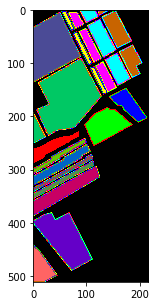

In [101]:
# Plot the Ground Truth Image
ground_truth = spectral.imshow(classes = y,figsize =(5,5))

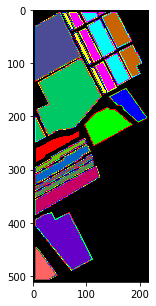

In [102]:
# Plot the Predicted image
outputs=generate_pridected_image()
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(5,5))